<a href="https://colab.research.google.com/github/ranja-sarkar/DecisionTree/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> Characteristics of **random forest** or **bagging ensemble** of trees (baseline, non-parametric model):
>
>> It's kind of robust, trains fast.

>> It's well suited for mixed datatypes.

>> As it's bootstrap aggregation ensemble, it decreases variance (does not overfit). There's in general overfitting with a single decision tree.

>> Model performance metric to some extent is a function of the number of estimators (trees) used while training.

>> It can handle nonlinear problems and has good out-of-the-box performance.

>> It performs implicit feature selection via the feature splitting criterion at each node; it is not immune to irrelevant features, and considers only a fixed number of randomly selected features at each node.

> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from numpy import mean
import missingno as msn

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import shap

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold

# Data

In [ ]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')
print(df_train.shape, df_test.shape)

#df_train = df_train.dropna(how = 'all', axis = 0) #drop empty rows if any
#df_train.dtypes

(10000, 16) (2000, 15)


<Axes: >

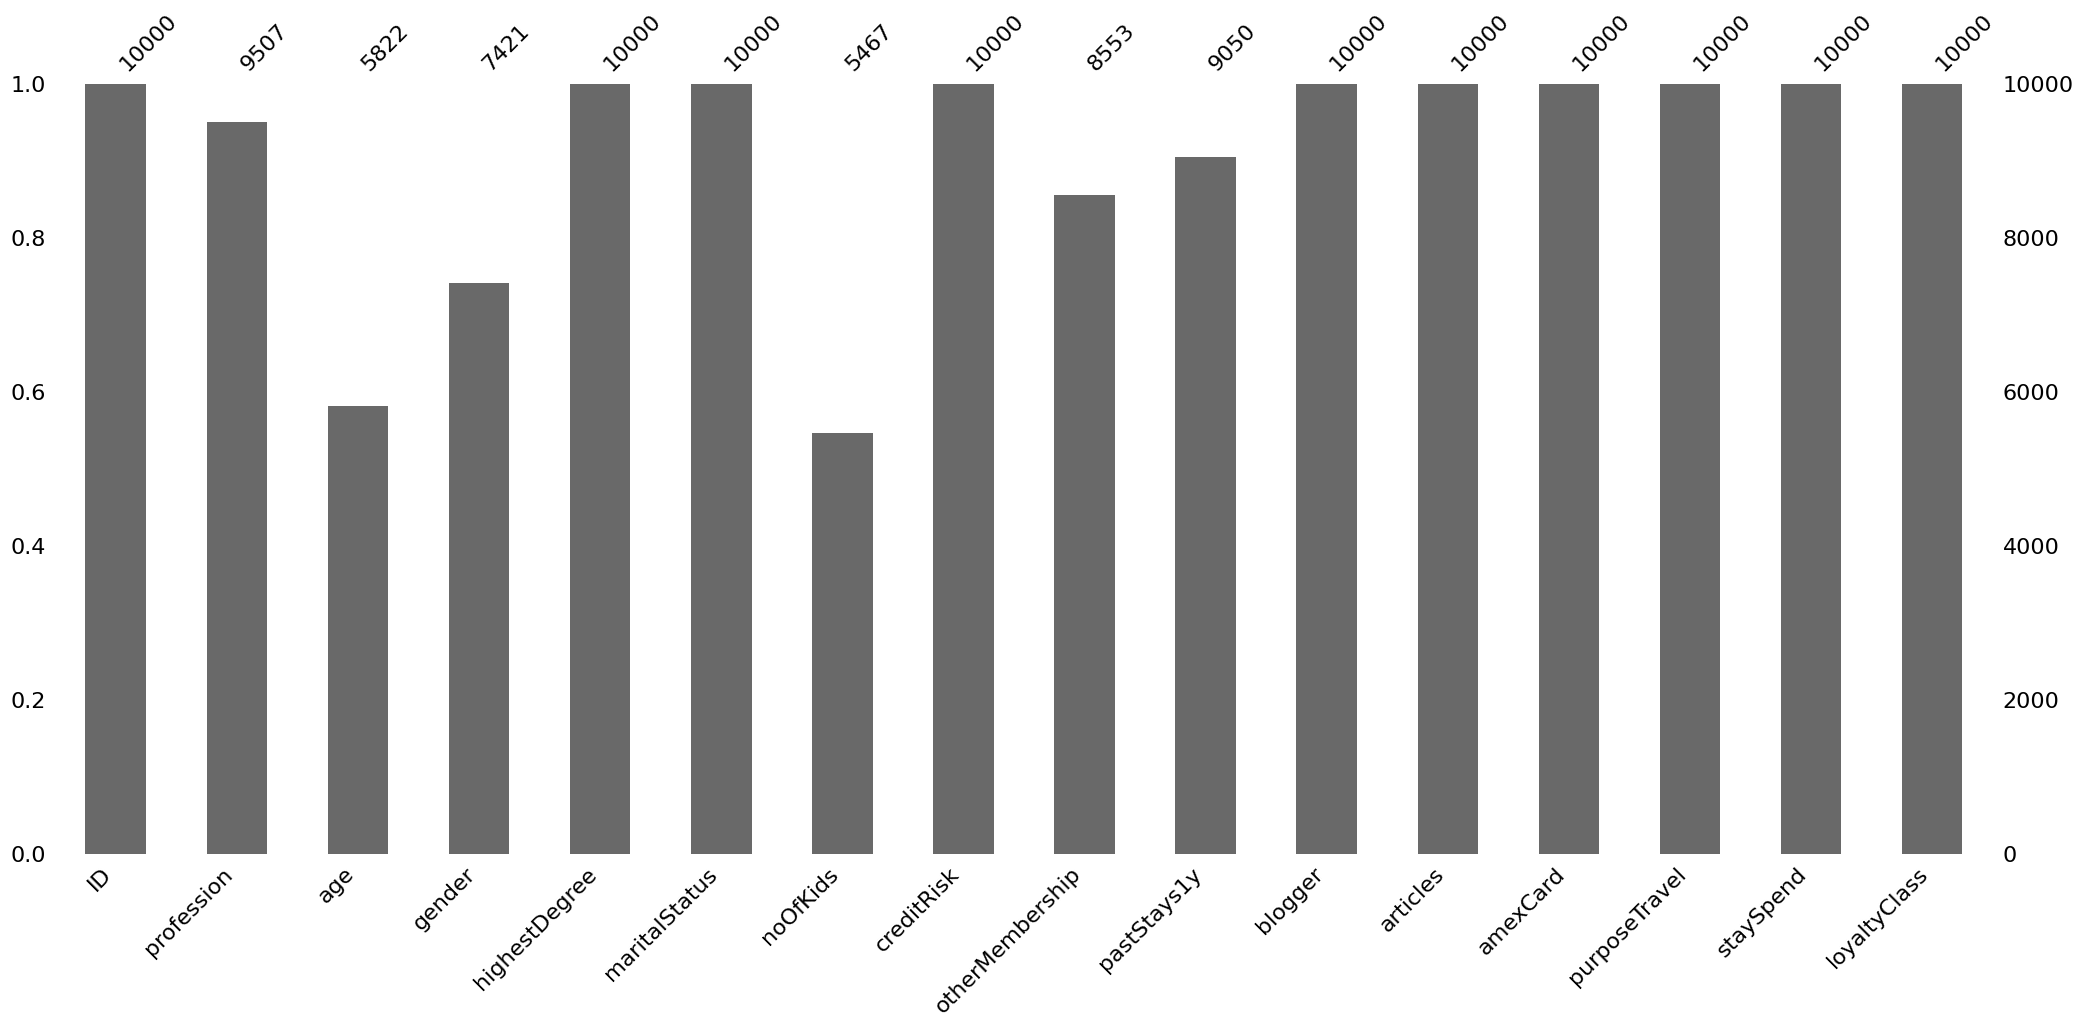

In [ ]:
msn.bar(df_train)    #color = 'blue'

In [ ]:
#msn.matrix(df_train)
#msn.dendrogram(df_train)

#msn.heatmap(df_test)

               count         mean          std   min    25%       50%  \
age           5822.0    39.100481    12.411516  18.0  28.00  39.00000   
noOfKids      5467.0     0.832632     1.018477   0.0   0.00   1.00000   
creditRisk   10000.0     2.889681     0.492806   1.0   2.56   2.89000   
pastStays1y   9050.0    24.719337    14.391174   0.0  12.00  25.00000   
articles     10000.0     7.407800     6.816183   0.0   0.00   6.00000   
staySpend    10000.0  1950.964931  5551.342403   0.0   0.00   0.26747   

                    75%          max  
age           50.000000     60.00000  
noOfKids       1.000000      4.00000  
creditRisk     3.230000      4.00000  
pastStays1y   37.000000     49.00000  
articles      13.000000     20.00000  
staySpend    781.467816  75553.55889  


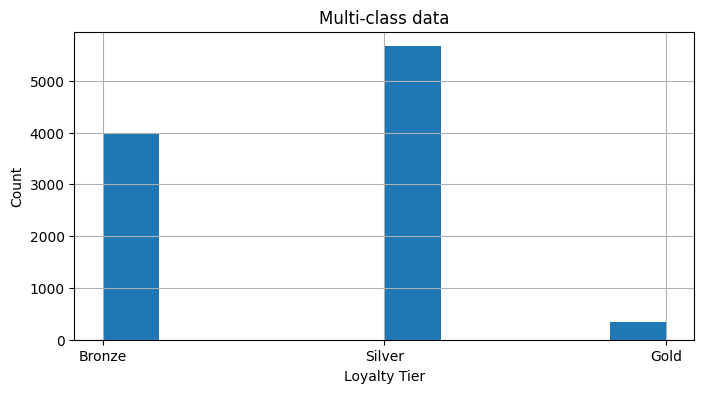

In [ ]:
def variables_plot(df, col):

    """
    Function: Describes and plots data classes
    Arguments: Dataframe, target feature

    """

    #df.hist(figsize = (9,7))
    df[col].hist(figsize = (8,4))
    plt.xlabel('Loyalty Tier')
    plt.ylabel('Count')
    plt.title('Multi-class data')
    df_stats = df.drop('ID', axis = 1)
    print(df_stats.describe().T)
    return plt.show()


variables_plot(df_train, 'loyaltyClass')

> Label encoding categorical variables

In [ ]:
le = LabelEncoder()

df_train['profession'] = le.fit_transform(df_train['profession']).astype('str')
df_test['profession'] = le.fit_transform(df_test['profession']).astype('str')

df_train['gender'] = le.fit_transform(df_train['gender']).astype('str')
df_test['gender'] = le.fit_transform(df_test['gender']).astype('str')

df_train['highestDegree'] = le.fit_transform(df_train['highestDegree']).astype('str')
df_test['highestDegree'] = le.fit_transform(df_test['highestDegree']).astype('str')

df_train['maritalStatus'] = le.fit_transform(df_train['maritalStatus']).astype('str')
df_test['maritalStatus'] = le.fit_transform(df_test['maritalStatus']).astype('str')

df_train['otherMembership'] = le.fit_transform(df_train['otherMembership']).astype('str')
df_test['otherMembership'] = le.fit_transform(df_test['otherMembership']).astype('str')

df_train['blogger'] = le.fit_transform(df_train['blogger']).astype('str')
df_test['blogger'] = le.fit_transform(df_test['blogger']).astype('str')

df_train['amexCard'] = le.fit_transform(df_train['amexCard']).astype('str')
df_test['amexCard'] = le.fit_transform(df_test['amexCard']).astype('str')

df_train['purposeTravel'] = le.fit_transform(df_train['purposeTravel']).astype('str')
df_test['purposeTravel'] = le.fit_transform(df_test['purposeTravel']).astype('str')

df_train['loyaltyClass'] = le.fit_transform(df_train['loyaltyClass']).astype('str')


<Axes: >

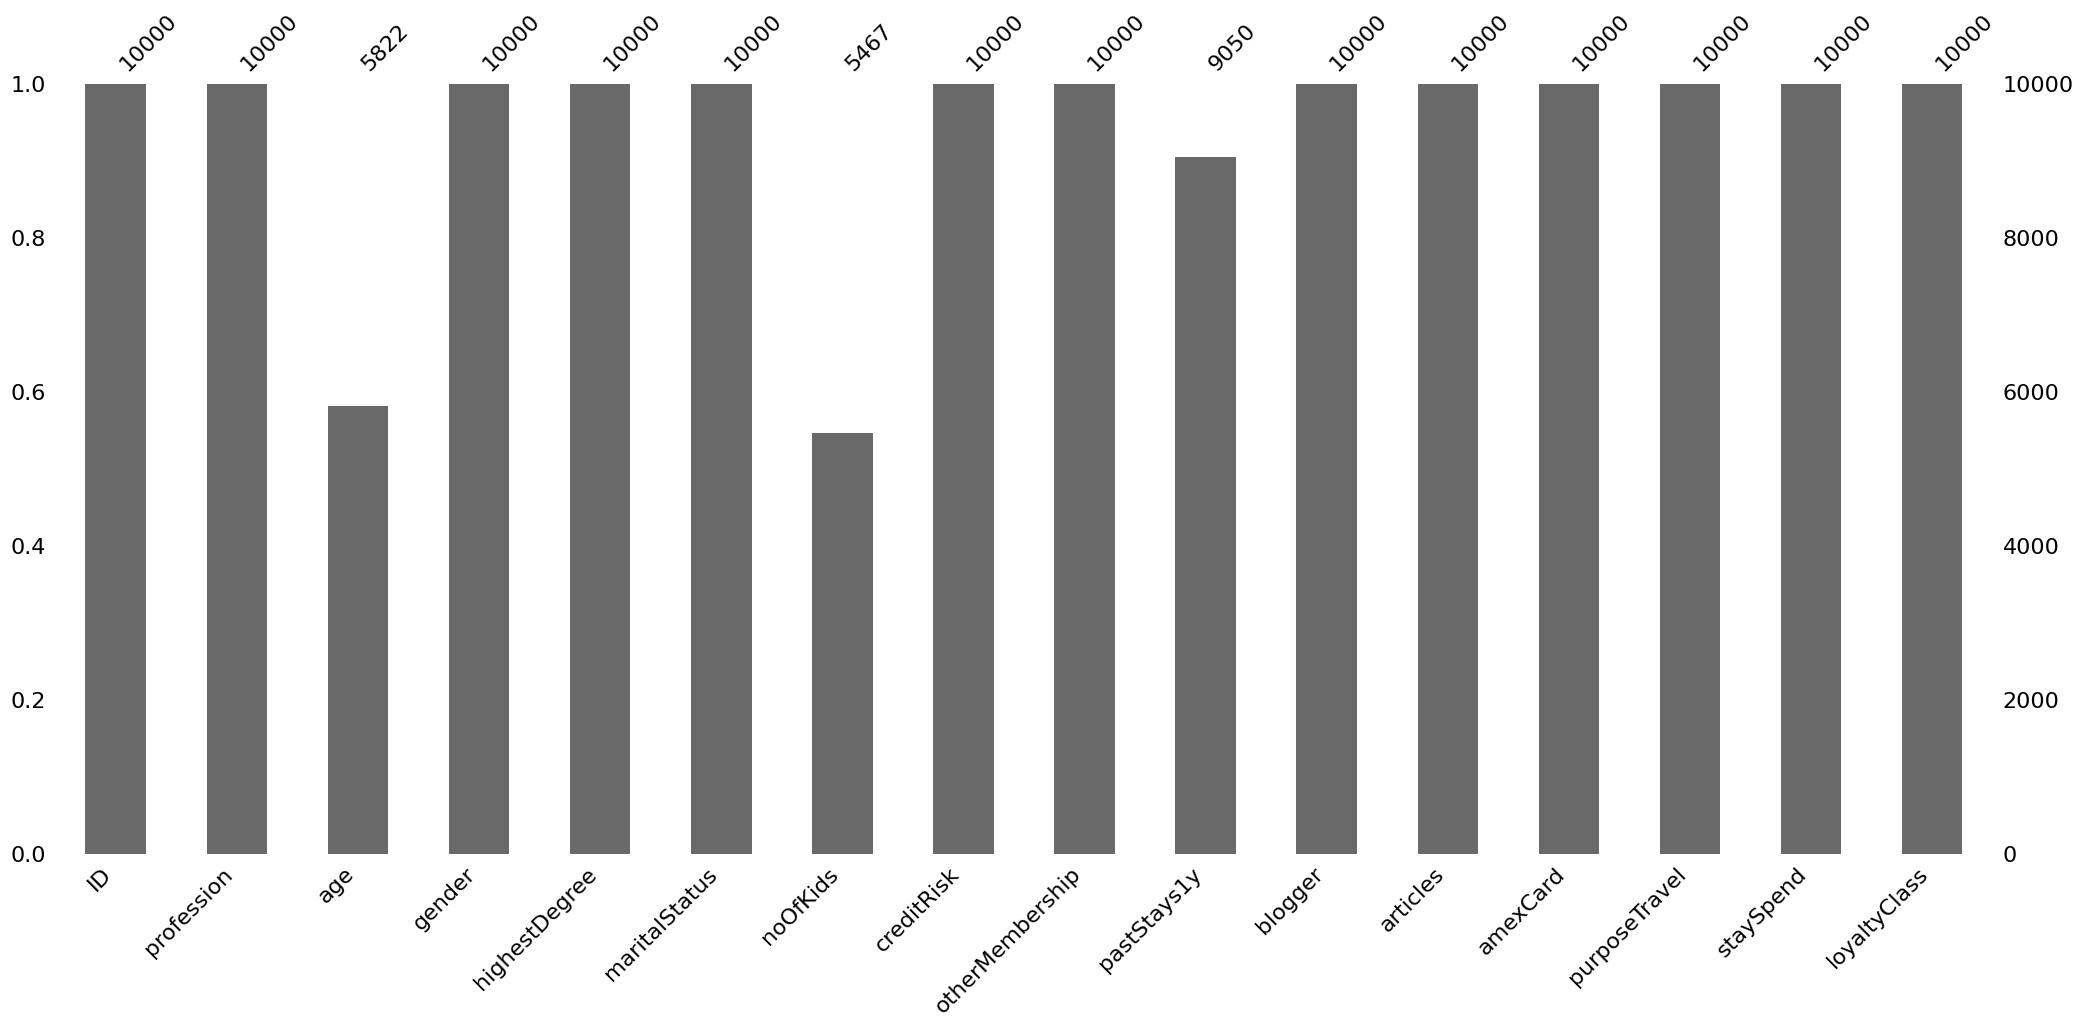

In [ ]:
#msn.bar(df_test, color = 'green')
msn.bar(df_train)

> Filling in missing values

In [ ]:
df_train['age'].fillna(df_train['age'].mean())
df_test['age'].fillna(df_test['age'].mean())

df_train['noOfKids'].fillna(0)
df_test['noOfKids'].fillna(0)

df_train['pastStays1y'].fillna(0)
df_test['pastStays1y'].fillna(0)

,pastStays1y
0,33.0
1,17.0
2,33.0
3,23.0
4,21.0
...,...
1995,0.0
1996,44.0
1997,0.0
1998,30.0


In [ ]:
#sns.pairplot(df_train, hue = 'loyaltyClass', vars = ['age', 'noOfKids', 'creditRisk', 'pastStays1y', 'articles', 'staySpend'], corner = True)

#sns.pairplot(df_train, hue = 'loyaltyClass', corner = True)

> Minmax Scaling of train data

In [ ]:
df_column_names = list(df_train.columns)
df_column_names.remove('loyaltyClass')

x = df_train.loc[:, df_train.columns != 'loyaltyClass'].values  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(data = x_scaled, columns = df_column_names)
df_normalized.head(5)

,ID,profession,age,gender,highestDegree,maritalStatus,noOfKids,creditRisk,otherMembership,pastStays1y,blogger,articles,amexCard,purposeTravel,staySpend
0,0.0000,0.50,NaN,0.5,0.428571,0.666667,0.00,0.726667,0.500000,0.469388,0.0,0.35,1.0,1.0,0.018969
1,0.0001,0.25,NaN,1.0,0.000000,0.333333,0.25,0.356667,0.500000,0.979592,0.0,0.20,1.0,0.5,0.000508
2,0.0002,0.00,0.619048,0.0,0.714286,0.333333,NaN,0.603333,0.000000,0.653061,0.0,0.05,0.0,0.5,0.000000
3,0.0003,0.50,NaN,0.5,0.142857,0.666667,0.00,0.820000,0.500000,0.122449,0.0,0.80,1.0,1.0,0.000000
4,0.0004,0.00,NaN,0.0,0.142857,1.000000,NaN,0.736667,0.833333,NaN,1.0,0.00,0.0,0.0,0.010118


<Axes: >

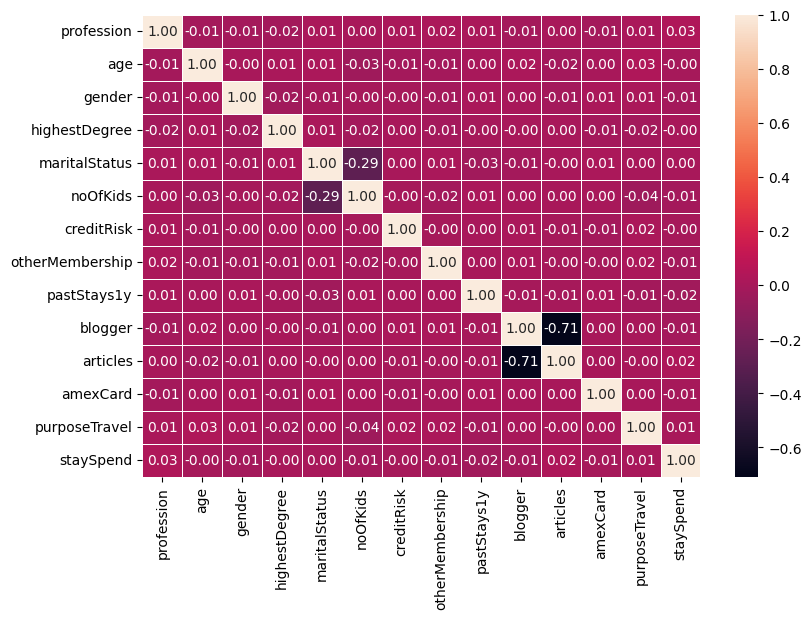

In [ ]:
plt.figure(figsize = (9, 6))
sns.heatmap(df_normalized.drop('ID', axis = 1).corr(), annot = True, fmt = '.2f', linewidths = 0.6)

> Minmax scaling of test data

In [ ]:
dff_column_names = list(df_test.columns)

xt = df_test.loc[:,].values                    #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xt)
dff_normalized = pd.DataFrame(data = x_scaled, columns = dff_column_names)
dff_normalized.head()

,ID,profession,age,gender,highestDegree,maritalStatus,noOfKids,creditRisk,otherMembership,pastStays1y,blogger,articles,amexCard,purposeTravel,staySpend
0,0.000000,0.00,NaN,0.0,0.428571,1.000000,0.50,0.656250,0.833333,0.673469,1.0,0.00,1.0,1.0,0.010070
1,0.000500,0.50,0.095238,0.0,0.428571,0.000000,0.25,0.840278,0.833333,0.346939,0.0,0.20,0.0,0.5,0.115630
2,0.001001,0.50,NaN,0.5,0.000000,0.333333,0.00,0.486111,1.000000,0.673469,1.0,0.00,1.0,0.5,0.000631
3,0.001501,0.50,0.214286,0.5,0.000000,0.000000,NaN,0.715278,0.500000,0.469388,0.0,0.60,0.0,0.0,0.000000
4,0.002001,0.25,NaN,1.0,1.000000,0.333333,0.25,0.638889,0.500000,0.428571,0.0,0.05,0.0,0.5,0.000571


> Setting up predictor variables and the target

In [ ]:
df_normalized_target = pd.concat([df_normalized, df_train['loyaltyClass']], axis = 1)

X = df_normalized_target[list(df_normalized_target.columns)[0:15]]
print(X.shape)

Y = df_normalized_target[list(df_normalized_target.columns)[-1]]
print(Y.shape)

(10000, 15)
(10000,)


# Resampling: oversampling

> Generate new samples in the classes which are under-represented by random oversampling.

>> https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling


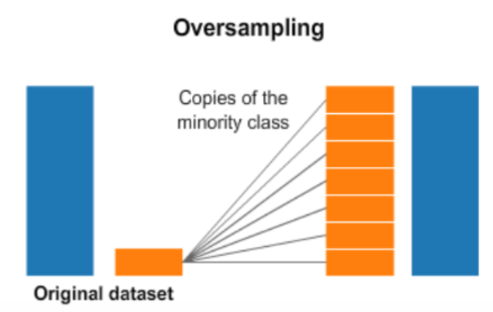

In [ ]:
#strategy = {0:6000, 1:6000, 2:6000}
#x, y = make_imbalance(X, Y, sampling_strategy = strategy, random_state = 42)


oversample = RandomOverSampler(sampling_strategy = 'minority')
x, y = oversample.fit_resample(X, Y)
print(Counter(y))

Counter({'2': 5665, '1': 5665, '0': 3998})


> **SMOTE** is another method - Synthetic Minority Oversampling Technique by which new samples are generated by interpolation. SMOTE uses the kNN algorithm to synthesize samples.

>> https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn


>> We continue with **Random Oversampling** here in this case study.

>> Data splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

# Model

>> **Model training (criterion is Gini index by default)**

In [ ]:
rfc1 = RandomForestClassifier(n_estimators = 100, random_state = 42)            #class_weight = 'balanced'
rfc1.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#rfc1.get_params()

In [ ]:
rfc_pred1 = rfc1.predict(x_test)

#print ("Train Accuracy=", metrics.accuracy_score(y_train, rfc1.predict(x_train)))
print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred1), 2))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred1))
print('Classification Report:')
print(classification_report(y_test, rfc_pred1))

Test Accuracy= 0.77
Confusion Matrix (True label vs. Predicted label):
[[ 394    0  603]
 [   0 1378    0]
 [ 294    0 1163]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       997
           1       1.00      1.00      1.00      1378
           2       0.66      0.80      0.72      1457

    accuracy                           0.77      3832
   macro avg       0.74      0.73      0.73      3832
weighted avg       0.76      0.77      0.76      3832



              count         mean          std    min    25%        50%  \
age          1138.0    38.783831    12.243815  18.00  28.00  39.000000   
noOfKids     1116.0     0.830645     0.986452   0.00   0.00   1.000000   
creditRisk   2000.0     2.882825     0.497648   1.12   2.55   2.890000   
pastStays1y  1805.0    24.026593    14.281357   0.00  12.00  24.000000   
articles     2000.0     7.664500     6.921553   0.00   0.00   7.000000   
staySpend    2000.0  1874.478352  5616.555419   0.00   0.00   0.152998   

                    75%          max  
age           49.000000     60.00000  
noOfKids       1.000000      4.00000  
creditRisk     3.220000      4.00000  
pastStays1y   36.000000     49.00000  
articles      14.000000     20.00000  
staySpend    852.937309  58905.79461  


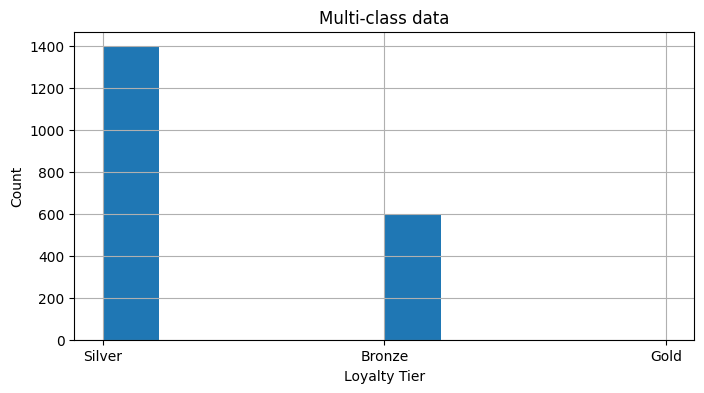

In [ ]:
XT = dff_normalized[list(dff_normalized.columns)[0:15]]

pred1 = rfc1.predict(XT)

results1 = pd.DataFrame(pred1, columns = ['Predicted loyaltyClass'])
dfc1 = pd.concat([df_test, results1], axis = 1)
#dfc1.shape

dfc1.loc[(dfc1['Predicted loyaltyClass'] == '0'), 'loyaltyTier'] = 'Bronze'
dfc1.loc[(dfc1['Predicted loyaltyClass'] == '1'), 'loyaltyTier'] = 'Gold'
dfc1.loc[(dfc1['Predicted loyaltyClass'] == '2'), 'loyaltyTier'] = 'Silver'

variables_plot(dfc1, 'loyaltyTier')

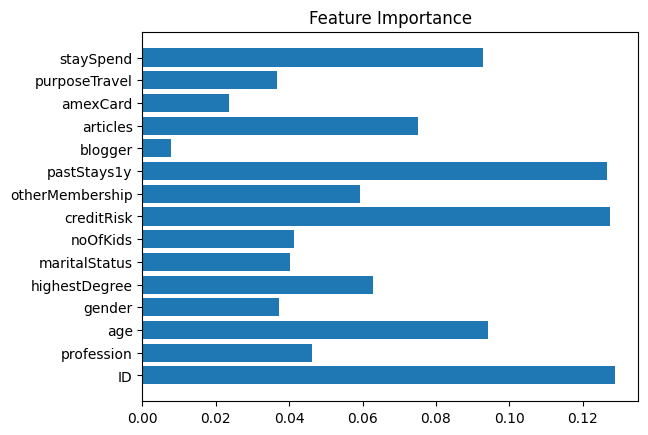

In [ ]:
plt.barh(dff_normalized.columns, rfc1.feature_importances_)
plt.title ('Feature Importance')
plt.show()

>> SHAP: https://github.com/shap/shap


In [2]:
#def features(model_obj, x):
#    """
#    Function: Displays SHAP values of features
#    Arguments: Trained model, feature test dataframe

#    """

#    explainer = shap.TreeExplainer(model_obj)
#    shap_vals = explainer.shap_values(x)

    #return shap.plots.beeswarm(shap_vals)
#    return shap.summary_plot(shap_vals, x, plot_size = (5, 5))
    #return shap.plots.bar(shap_vals)

#features(rfc1, XT)

>> **Model training with entropy criterion**

In [ ]:
rfc2 = RandomForestClassifier(criterion = "entropy", n_estimators = 100, random_state = 42)
rfc2.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [ ]:
rfc_pred2 = rfc2.predict(x_test)

print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred2), 2))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred2))
print('Classification Report:')
print(classification_report(y_test, rfc_pred2))

Test Accuracy= 0.77
Confusion Matrix (True label vs. Predicted label):
[[ 402    0  595]
 [   0 1378    0]
 [ 303    0 1154]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       997
           1       1.00      1.00      1.00      1378
           2       0.66      0.79      0.72      1457

    accuracy                           0.77      3832
   macro avg       0.74      0.73      0.73      3832
weighted avg       0.76      0.77      0.76      3832



              count         mean          std    min    25%        50%  \
age          1138.0    38.783831    12.243815  18.00  28.00  39.000000   
noOfKids     1116.0     0.830645     0.986452   0.00   0.00   1.000000   
creditRisk   2000.0     2.882825     0.497648   1.12   2.55   2.890000   
pastStays1y  1805.0    24.026593    14.281357   0.00  12.00  24.000000   
articles     2000.0     7.664500     6.921553   0.00   0.00   7.000000   
staySpend    2000.0  1874.478352  5616.555419   0.00   0.00   0.152998   

                    75%          max  
age           49.000000     60.00000  
noOfKids       1.000000      4.00000  
creditRisk     3.220000      4.00000  
pastStays1y   36.000000     49.00000  
articles      14.000000     20.00000  
staySpend    852.937309  58905.79461  


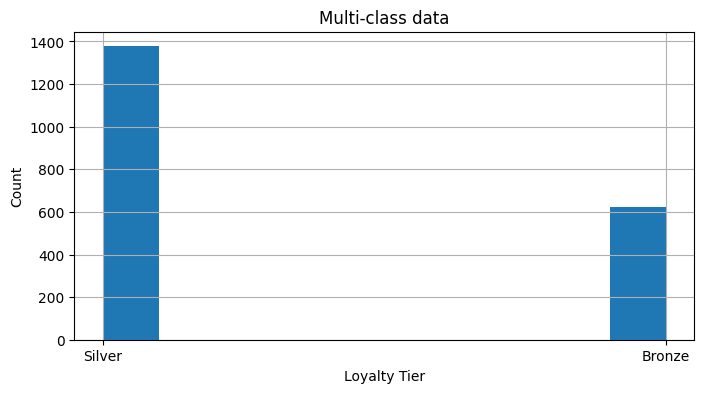

In [ ]:
pred2 = rfc2.predict(XT)

results2 = pd.DataFrame(pred2, columns = ['Predicted loyaltyClass'])
dfc2 = pd.concat([df_test, results2], axis = 1)

dfc2.loc[(dfc2['Predicted loyaltyClass'] == '0'), 'loyaltyTier'] = 'Bronze'
dfc2.loc[(dfc2['Predicted loyaltyClass'] == '1'), 'loyaltyTier'] = 'Gold'
dfc2.loc[(dfc2['Predicted loyaltyClass'] == '2'), 'loyaltyTier'] = 'Silver'

variables_plot(dfc2, 'loyaltyTier')

> Results do not make much difference with different criteria.

# Resampling: undersampling

> Balance the data by randomly selecting a subset of data for the targeted classes

>> https://imbalanced-learn.org/stable/under_sampling.html#random-under-sampling


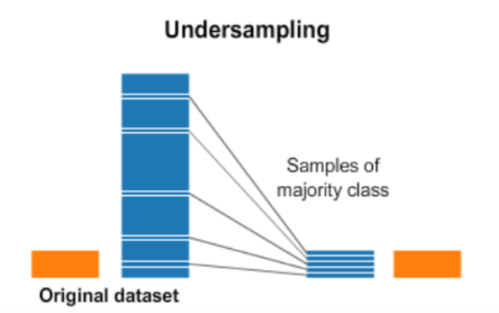

In [ ]:
undersample = RandomUnderSampler(sampling_strategy = 'majority')
x, y = undersample.fit_resample(X, Y)
print(Counter(y))

Counter({'0': 3998, '1': 337, '2': 337})


>> Data splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

>> **Model training with entropy**

In [ ]:
rfc3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
rfc3.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [ ]:
rfc_pred3 = rfc3.predict(x_test)

print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred3), 2))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred3))
print('Classification Report:')
print(classification_report(y_test, rfc_pred3))

Test Accuracy= 0.85
Confusion Matrix (True label vs. Predicted label):
[[988   0   0]
 [ 89   0   0]
 [ 91   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       988
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00        91

    accuracy                           0.85      1168
   macro avg       0.28      0.33      0.31      1168
weighted avg       0.72      0.85      0.78      1168



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              count         mean          std    min    25%        50%  \
age          1138.0    38.783831    12.243815  18.00  28.00  39.000000   
noOfKids     1116.0     0.830645     0.986452   0.00   0.00   1.000000   
creditRisk   2000.0     2.882825     0.497648   1.12   2.55   2.890000   
pastStays1y  1805.0    24.026593    14.281357   0.00  12.00  24.000000   
articles     2000.0     7.664500     6.921553   0.00   0.00   7.000000   
staySpend    2000.0  1874.478352  5616.555419   0.00   0.00   0.152998   

                    75%          max  
age           49.000000     60.00000  
noOfKids       1.000000      4.00000  
creditRisk     3.220000      4.00000  
pastStays1y   36.000000     49.00000  
articles      14.000000     20.00000  
staySpend    852.937309  58905.79461  


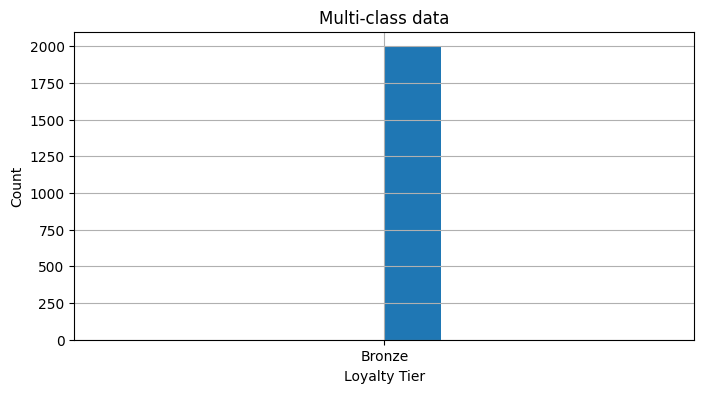

In [ ]:
XT = dff_normalized[list(dff_normalized.columns)[0:15]]

pred3 = rfc3.predict(XT)

results = pd.DataFrame(pred3, columns = ['Predicted loyaltyClass'])
dfc3 = pd.concat([df_test, results], axis = 1)

dfc3.loc[(dfc3['Predicted loyaltyClass'] == '0'), 'loyaltyTier'] = 'Bronze'
dfc3.loc[(dfc3['Predicted loyaltyClass'] == '1'), 'loyaltyTier'] = 'Gold'
dfc3.loc[(dfc3['Predicted loyaltyClass'] == '2'), 'loyaltyTier'] = 'Silver'

variables_plot(dfc3, 'loyaltyTier')

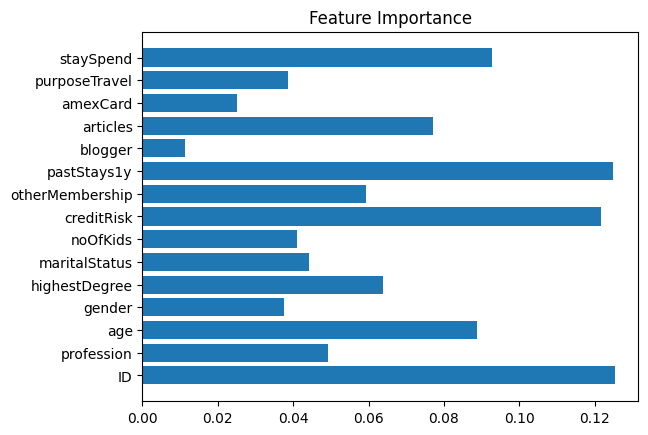

In [ ]:
plt.barh(dff_normalized.columns, rfc3.feature_importances_)
plt.title ('Feature Importance')
plt.show()

In [3]:
#features(rfc3, XT)

>> **Model training with Gini index**

In [ ]:
rfc4 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
rfc4.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rfc_pred4 = rfc4.predict(x_test)

print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred4), 2))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred4))
print('Classification Report:')
print(classification_report(y_test, rfc_pred4))

Test Accuracy= 0.85
Confusion Matrix (True label vs. Predicted label):
[[988   0   0]
 [ 89   0   0]
 [ 91   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       988
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00        91

    accuracy                           0.85      1168
   macro avg       0.28      0.33      0.31      1168
weighted avg       0.72      0.85      0.78      1168



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              count         mean          std    min    25%        50%  \
age          1138.0    38.783831    12.243815  18.00  28.00  39.000000   
noOfKids     1116.0     0.830645     0.986452   0.00   0.00   1.000000   
creditRisk   2000.0     2.882825     0.497648   1.12   2.55   2.890000   
pastStays1y  1805.0    24.026593    14.281357   0.00  12.00  24.000000   
articles     2000.0     7.664500     6.921553   0.00   0.00   7.000000   
staySpend    2000.0  1874.478352  5616.555419   0.00   0.00   0.152998   

                    75%          max  
age           49.000000     60.00000  
noOfKids       1.000000      4.00000  
creditRisk     3.220000      4.00000  
pastStays1y   36.000000     49.00000  
articles      14.000000     20.00000  
staySpend    852.937309  58905.79461  


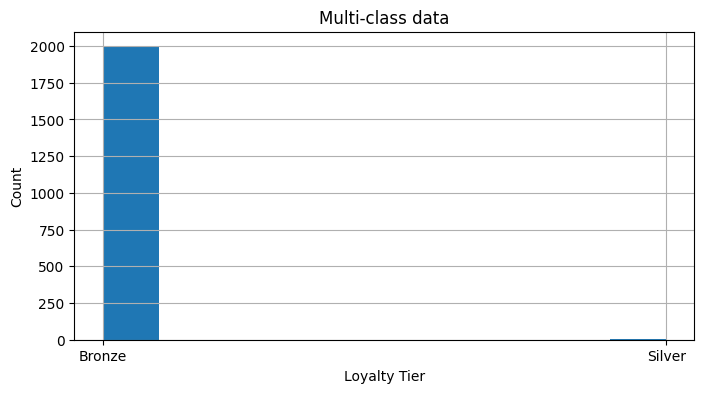

In [ ]:
pred4 = rfc4.predict(XT)
results = pd.DataFrame(pred4, columns = ['Predicted loyaltyClass'])
dfc4 = pd.concat([df_test, results], axis = 1)

dfc4.loc[(dfc4['Predicted loyaltyClass'] == '0'), 'loyaltyTier'] = 'Bronze'
dfc4.loc[(dfc4['Predicted loyaltyClass'] == '1'), 'loyaltyTier'] = 'Gold'
dfc4.loc[(dfc4['Predicted loyaltyClass'] == '2'), 'loyaltyTier'] = 'Silver'

variables_plot(dfc4, 'loyaltyTier')

> The accuracy is 85% for model trained with undersampled data, as opposed to 77% for model trained with oversampled data.

>> RF model predictions for customer classes with oversampled data however follow a similar distribution as the training data, which is not followed with undersampled data.

# Discussion

> Gini index tends to be less sensitive to class imbalance, as it works to minimize the misclassification error.

> The model predictions change when the probability threshold or decision threshold changes. By default, the threshold is set to 0.5 in scikit-klearn assuming balance in the dataset (in its target class).

Here's how to tune the threshold: https://scikit-learn.org/1.5/modules/classification_threshold.html

>> It is shown by researchers that optimizing the decision threshold is as effective as random oversampling.



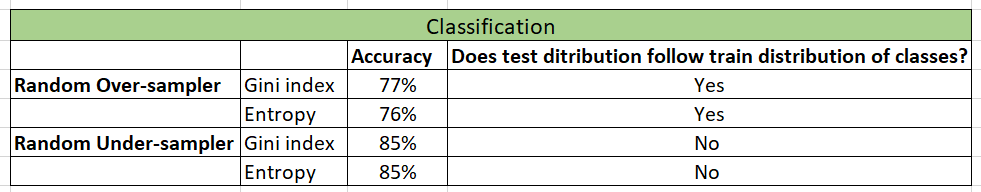